In [27]:
import numpy as np
import matplotlib.pyplot as plt
import PQS_solver_v2 as PQS
import qutip as qt
from iminuit import Minuit
from iminuit.cost import LeastSquares
from matplotlib.pyplot import figure

# Setting up system

In [28]:
N_rabi = 15 # Number if different magnetic momnent strengths
gauss_sigma = 1
N_states = N_rabi # number of different singnal states
t_gamma = 50 # time of the simulation
gamma = 1 # characteristic decay rate

t = t_gamma / gamma # time of the simulation
dt = 0.01 # time step of the simulation
N_t = int(t / dt + 1) # number of time steps
times = np.linspace(0, t, N_t, endpoint=True) # time steps
mu1 = 1 # magnetic moment of the qubit
mu2 = 1 # magnetic moment of thee_op = lambda i : [c_out_1_1_e(i) + c_out_1_2_e(i).dag(), c_out_1_1_e_dag(i) + c_out_1_2_e_dag(i).dag()] qubit
seed_signal = 46 # seed for random number generator for the signal
seed_simulation = 9 # seed for random number generator for the simulation
t_signal_leadin = 0 # time for the stocastic nature of the signal to not be at 0 as the begining of the simulation
gamma_decay = gamma # decay rate of qubit out of cavityFisher_information_error[0, 0], label='Fisher information error', color='black', alpha=0.5
gamma_phi = gamma # dephasing rate of qubit
t_plot = np.linspace(0, t * gamma, N_t)
rabi_min, rabi_max = 4.0, 6.0 # range of the magnetic moment
rabi_step = (rabi_max - rabi_min) / N_rabi # step size of the magnetic moment
theta_min, theta_max = 0, 0#-1/10 * np.pi, 1/10 * np.pi # range of the angle of the magnetic moment
# true angle of the magnetic moment
methode = 'Kraus' # methode used for the ODE solver
p = 0.02 * gamma # transition rate 

field_type = 'uniform' # 'dipole' type of sensing field


save=False


dephase_strength = 0.00
entaglement = 'rabi' # 'entangled' or 'seperable' entangled state




beta_1 = np.array([1, 0, 0]) * 0.4# amplitude of driving field
beta_2 = np.array([0, 1, 0]) * 0.4# amplitude of driving field

cupling_strength = 0.0


        
N_t_leadin = int(t_signal_leadin / dt) # number of time steps for the leadin of the signal
    

# Simulate Signal

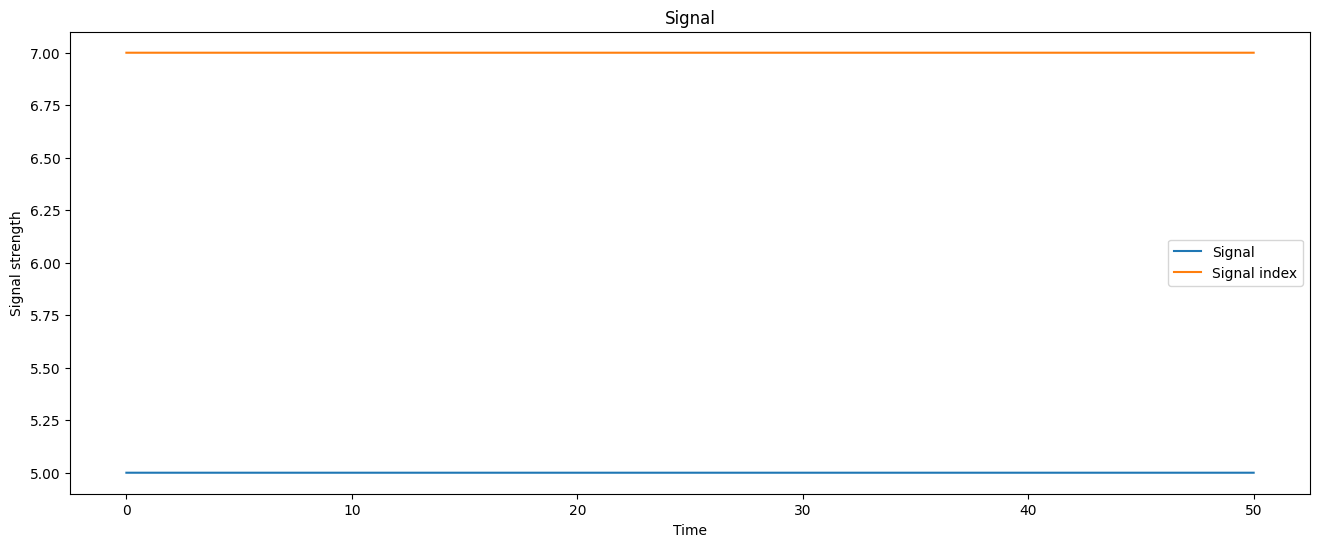

In [29]:
signal_type = 'constant'

rabi = 1
detuning = 0#1.43
gamma_rabi = 0.55

r_signal = np.random.default_rng(seed_signal) # random number generator for the signal

st = 0#0.003 # to regulate the transtion rate between HMM states

def gennerate_r_next_neighbour_jump(N, st):
    r = np.eye(N, k=0) * (1 - 2 * st)
    r += np.eye(N, k=1) * st
    r += np.eye(N, k=-1) * st
    r[0, 0] = 1 - st
    r[-1, -1] = 1 - st
    return r

r_HMM = gennerate_r_next_neighbour_jump(N_states, st / rabi_step)



# generate the signal
r_HMM_sim = np.zeros((N_states, N_states))

for i in range(N_states):
    for j in range(N_states):
        if i != j:
            r_HMM_sim[i, j] = r_HMM[i, j] * dt

for i in range(N_states):
    r_HMM_sim[i, i] = 1 - np.sum(r_HMM_sim[i, :])








t_B_1 = 0
delta_t_B_1 = t 
 
rabi_n_posible = np.linspace(rabi_min, rabi_max, N_rabi, endpoint=True)

rabi_n_index_0 = int(N_rabi / 2)

rabi_n_0 = rabi_n_posible[rabi_n_index_0]

rabi_n_list = np.zeros(N_t + N_t_leadin)
rabi_n_list_index = np.zeros(N_t + N_t_leadin, dtype=int)

rabi_n_list_index[0] = rabi_n_index_0
rabi_n_list[0] = rabi_n_0

# generate the signal
for i in range(1, N_t_leadin + N_t):
    q = r_signal.random()
    prob_sum = 0
    nr = 0
    while prob_sum < q:
        prob_sum += r_HMM_sim[rabi_n_list_index[i - 1], nr]
        nr += 1
    rabi_n_list_index[i] = nr - 1


rabi_n_list = rabi_n_posible[rabi_n_list_index]


rabi_n = lambda i: rabi_n_list[i]

rabi_n_index = lambda i: rabi_n_list_index[i]





#Delta_n_1 = np.ones(N_t) * B_1
#Delta_n_2 = np.ones(N_t) * B_1 * 0
#Delta_n_1_0 = np.ones(N_t)
#Delta_n_2_0 = np.ones(N_t)
#Delta_n_1 = np.linspace(-B_1, B_1, N_t, endpoint=True)

fig, ax = plt.subplots(1, figsize=(16, 6))

t_plot = np.linspace(0, t * gamma, N_t)

Blues = plt.get_cmap('Blues')

t_index = np.arange(0, N_t, 1)

ax.plot(t_plot, rabi_n(t_index), label='Signal')
ax.plot(t_plot, rabi_n_index(t_index), label='Signal index')


ax.set_title('Signal')
ax.set_xlabel('Time')
ax.set_ylabel('Signal strength')

#ax[1].set_title('Wiener process')
#ax[1].plot(t_plot, dW)

ax.legend()
plt.show()


# Simulate detection record

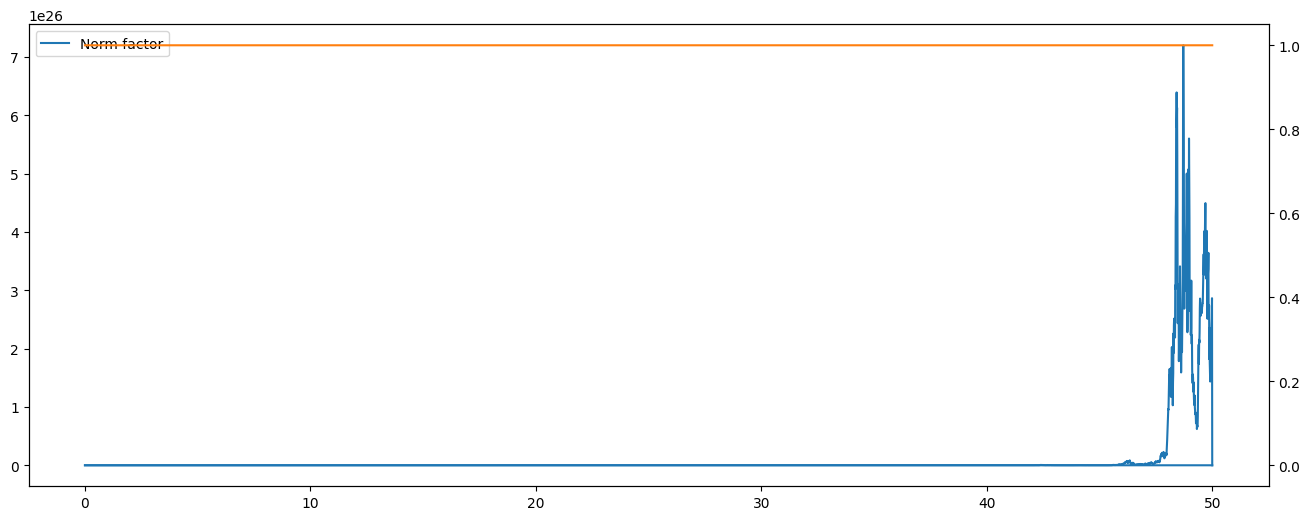

In [ ]:
alpha = 1 # splitting between homodyne and click, where alpha is the fraction of the click
gamma_decay = 5
kappa = 0

phi = np.pi/2

N_dim = 2

sigma_z = qt.jmat(N_dim/2 - 1/2, 'z')#qt.sig maz()# Pauli-Z operator for qubit
sigma_x = qt.jmat(N_dim/2 - 1/2, 'x')#qt.sigmax() # Pauli-X operator for qubit
sigma_y = qt.jmat(N_dim/2 - 1/2, 'y')#qt.sigmay() # Pauli-Y operator for qubit
sigma_p = qt.jmat(N_dim/2 - 1/2, '+')#qt.sigmap() # raising operator for qubit
sigma_m = qt.jmat(N_dim/2 - 1/2, '-')#qt.sigmam() # lowering operator for qubit


dec = 0
c_dec = lambda i : sigma_m * np.sqrt(gamma_decay * kappa)
c_ops = lambda i : [c_dec(i)]




c_w = lambda i : np.sqrt((1 - kappa) * (1 - alpha) * gamma_decay) * sigma_m * np.exp(phi * 1j)
sc_ops_w = lambda i : [c_w(i)]



#gamma_decay = 0#1/np.sqrt(2)
c_c = lambda i : sigma_m * np.sqrt((1 - kappa) * alpha * gamma_decay)
sc_ops_c = lambda i : [c_c(i)]




e_ops = lambda i : [sigma_x, sigma_y, sigma_z]



rho_0 = qt.basis(N_dim, 1) * qt.basis(N_dim, 1).dag()


rabi = 2
detuning = 0

H_rabi = lambda i : rabi_n(i) * sigma_x + detuning/2 * sigma_z 



Experiment = PQS.Experiment_simulation(H_rabi, rho_0, times, c_ops=c_ops, sc_ops_w=sc_ops_w, sc_ops_c=sc_ops_c, e_ops=e_ops) # not very elegant that one need to write the 1 at N_states
Experiment.solve_mixed()


fig, ax = plt.subplots(1, figsize=(16, 6))
ax.plot(times, Experiment.normfactor, label='Norm factor')
ax2 = ax.twinx()
ax2.plot(times, Experiment.dN, label='Expectation value')
ax.legend()

# Estimate Parametors

In [31]:
dY = Experiment.detection_record
dN = Experiment.dN
print(sum(dN))   

def gennerate_gaussian_state(N, mu, sigma):
    gauss_array = np.exp(-(np.arange(N) - mu)**2 / (2 * sigma**2))
    gauss_array /= np.sum(gauss_array)
    return gauss_array

gauss_array = gennerate_gaussian_state(N_states, rabi_n_index_0, gauss_sigma / rabi_step)

rho_HMM = [gauss_array[i] * rho_0 for i in range(N_states)]

#print(rho_HMM)



H_HMM = lambda i : rabi_n_posible[i] * sigma_x + detuning/2 * sigma_z 

J_index = []

for i in range(N_states):
    for j in range(N_states):
        if i != j:#if r_HMM_jump[i, j] != 0:
            if r_HMM[i, j] != 0:
                J_index.append([i, j])
                #J_HMM_list.append(qt.tensor(qt.qeye(2), np.sqrt(r_HMM_jump[i, j]) * qt.basis(N_states, j) * qt.basis(N_states, i).dag()))
            #J_HMM_list.append(qt.tensor(np.sqrt(r_HMM_sim[i, j]) * qt.basis(N_states, j) * qt.basis(N_states, i).dag(), qt.qeye(2)))
    
#print(J_HMM_list)
J_index = np.array(J_index)



Experiment_estimater = PQS.Experiment_estimation(H_HMM, rho_HMM, times, c_ops, sc_ops_w, sc_ops_c, e_ops, N_states, r_HMM)
#Experiment_estimater.solve_mixed(dY, dN)

Experiment_estimater.solve_mixed_PQS(dY, dN)



[   0. 5001.]


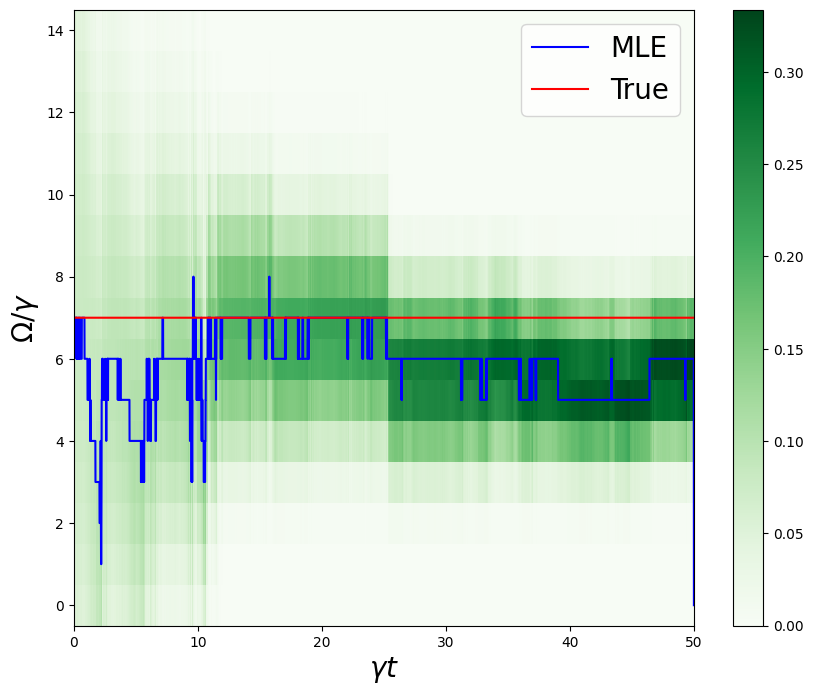

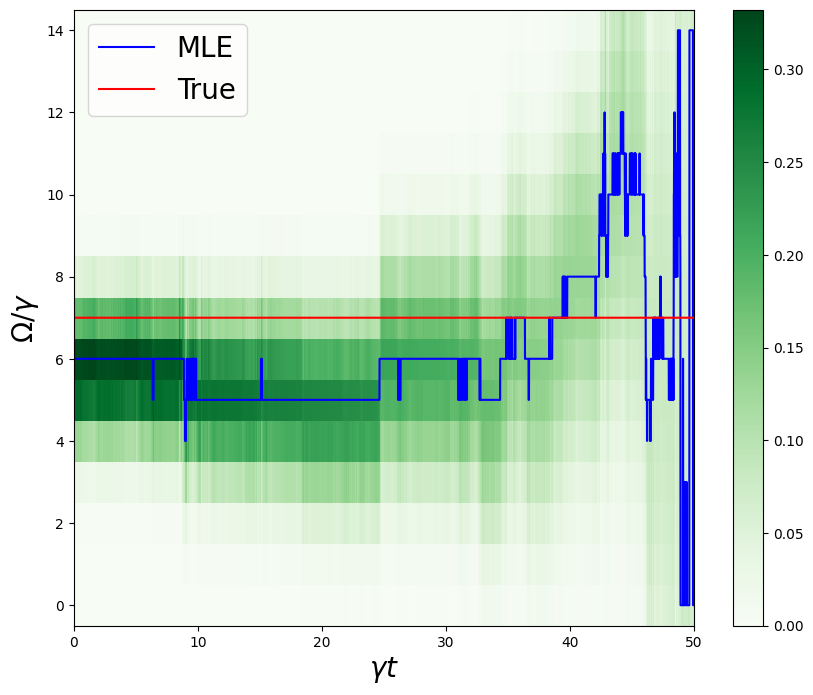

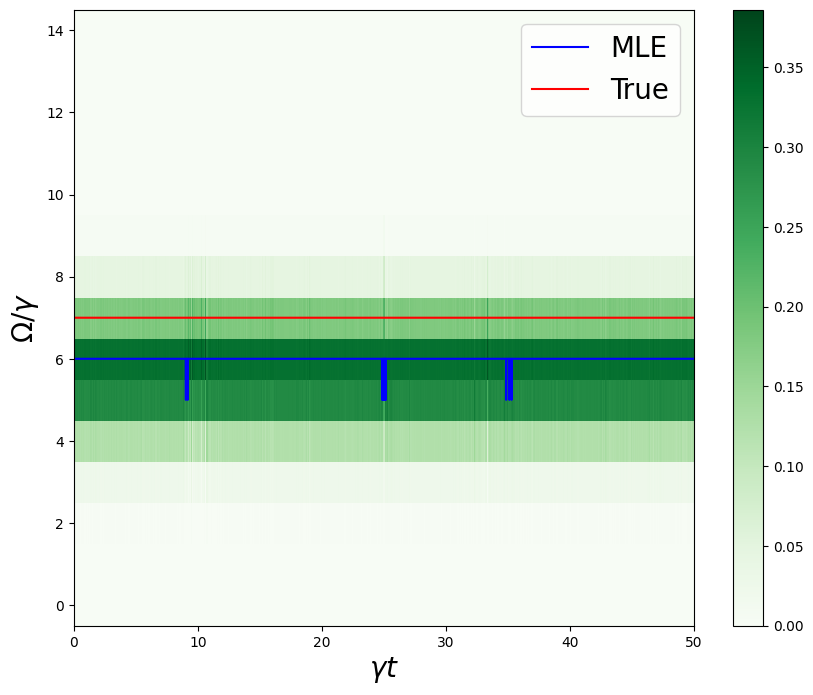

In [32]:


np.save(f'1_may_2025_PQS_alpha_{alpha}_stationery', Experiment_estimater.P_n_PQS)
np.save(f'1_may_2025_rho_alpha_{alpha}_stationery', Experiment_estimater.P_n_rho)
np.save(f'1_may_2025_E_alpha_{alpha}_stationery', Experiment_estimater.P_n_E)
np.save(f'1_may_2025_rabi_n_list_index_alpha_{alpha}_stationery', rabi_n_list_index)


P_n_PQS = np.load(f'1_may_2025_PQS_alpha_{alpha}_stationery.npy')
P_n_rho = np.load(f'1_may_2025_rho_alpha_{alpha}_stationery.npy')
P_n_E = np.load(f'1_may_2025_E_alpha_{alpha}_stationery.npy')
rabi_n_list_index = np.load(f'1_may_2025_rabi_n_list_index_alpha_{alpha}_stationery.npy')


save = True
title = 'homodyne og counting Rabi fequency estimation'
title_1 = title + 'forward'
title_2 = title + 'backward'
title_3 = title + 'forward and backward'

def plot_estimate_hist(time, estimate_signal, True_signal, N_states, title, save=False, filename='test', cmap='plasma'):
    #fig, ax = plt.subplots(figsize=(16, 8))
    text_size = 20
    figure(figsize=(10, 8))
    c = plt.imshow(estimate_signal.T, aspect='auto', extent=[0, 
                    time[-1], -1/2, N_states -1/2], origin='lower', 
                    cmap=cmap, vmin=0, interpolation='none')
    
    MLE = np.argmax(estimate_signal, axis=1)
    plt.plot(time, MLE, label='MLE', color='blue')
    plt.plot(time, True_signal, label='True', color='red')

    plt.xlabel('$\gamma t$', fontsize=text_size)
    plt.ylabel('$\Omega / \gamma$', fontsize=text_size)
    plt.legend(fontsize=text_size)
    plt.colorbar(c)
    
    if save:
        file_path = f'{filename}.png'
        plt.savefig(file_path)
    plt.show()



"""
plot_estimate_hist(t_plot, Experiment_estimater.P_n_rho.real, rabi_n_list_index, N_states, title_1, save=save, filename='21_november_not_entangled_hist', cmap='Greens')
plot_estimate_hist(t_plot, Experiment_estimater.P_n_E.real, rabi_n_list_index, N_states, title_2, save=save, filename='21_november_not_entangled_hist', cmap='Greens')
plot_estimate_hist(t_plot, Experiment_estimater.P_n_PQS.real, rabi_n_list_index, N_states, title_3, save=save, filename='21_november_not_entangled_hist', cmap='Greens')
"""
plot_estimate_hist(t_plot, P_n_rho.real, rabi_n_list_index, N_states, title_1, save=save, filename=f'1_may_2025_rho_hist_alpha_{alpha}', cmap='Greens')
plot_estimate_hist(t_plot, P_n_E.real, rabi_n_list_index, N_states, title_2, save=save, filename=f'1_may_2025_E_hist_alpha_{alpha}', cmap='Greens')
plot_estimate_hist(t_plot, P_n_PQS.real, rabi_n_list_index, N_states, title_3, save=save, filename=f'1_may_2025_PQS_hist_alpha_{alpha}', cmap='Greens')

[16.3376011  16.33772737 16.33782975 ...  1.32033618  1.31987814
  0.        ]
[7.         7.00058312 6.99431841 ... 5.66370082 5.66339587 0.        ]


/tmp/ipykernel_827881/3019297052.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  mean[i] = np.sum(P_n[i] * np.arange(N_states))
/tmp/ipykernel_827881/3019297052.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  variance[i] = np.sum(P_n[i] * (np.arange(N_states) - mean[i])**2)


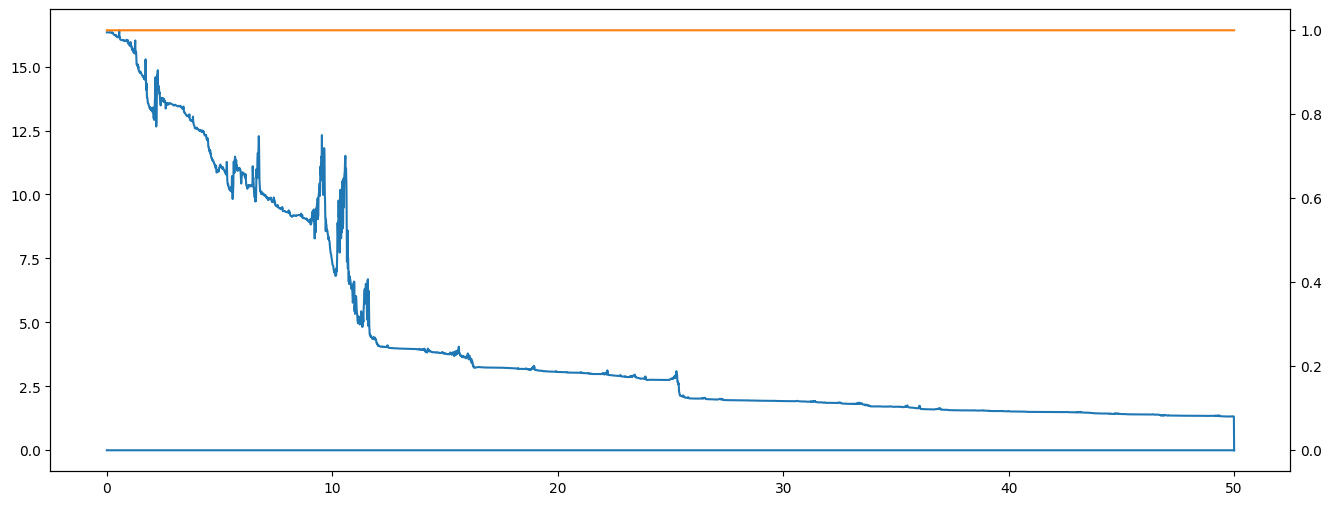

In [33]:
def calculate_variance(P_n, N_t, N_states):
        
    mean = np.zeros(N_t)
    variance = np.zeros(N_t)
    for i in range(N_t):
        mean[i] = np.sum(P_n[i] * np.arange(N_states))
        variance[i] = np.sum(P_n[i] * (np.arange(N_states) - mean[i])**2)
    return variance, mean




variance, mean = calculate_variance(Experiment_estimater.P_n_rho, N_t, N_states)

print(variance)
print(mean)


fag, ax = plt.subplots(1, figsize=(16, 6))

ax.plot(t_plot, variance, label='Variance')
ax_2 = ax.twinx()
ax_2.plot(t_plot, Experiment.dN, label='Mean')

In [34]:
variance_difference = np.diff(variance)
count_index = np.where(dN[:, 0] == 1)[0]

index_list = np.zeros(N_t-1, dtype=int)
index = 0
for i in range(N_t - 1):
    if dN[:, 0][i] == 1:
        index = 0
    else:
        index += 1
    
    index_list[i] = index





m_fit :  1.842615257260755e-06 +-  9.797959084122822e-07
b_fit :  -0.007874979672287067 +-  0.0028288514202571553


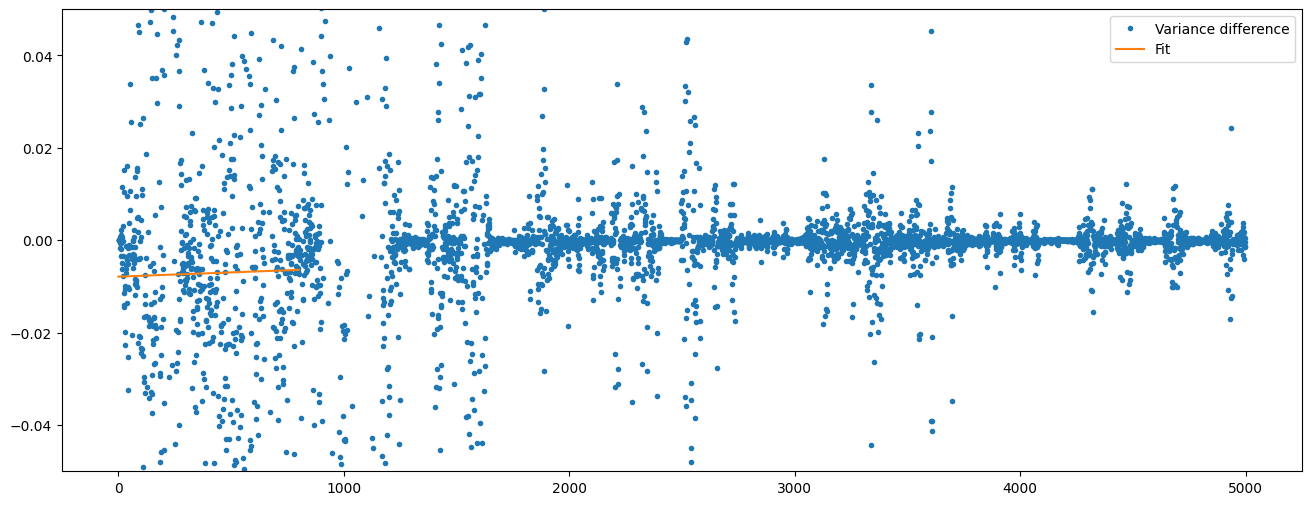

In [35]:
def lin_fit(x, m, b):
    return m * x + b

least_squares = LeastSquares(index_list, variance_difference, np.ones(N_t-1) * np.sqrt(dt), lin_fit)

m = Minuit(least_squares, m=0, b=0)

m.migrad()

m_fit = m.values[0]
b_fit = m.values[1]

print('m_fit : ', m_fit, '+- ', m.errors[0])
print('b_fit : ', b_fit, '+- ', m.errors[1])

xx = np.linspace(0, 800, 1000)
yy = lin_fit(xx, m_fit, b_fit)



fig, ax = plt.subplots(1, figsize=(16, 6))
ax.plot(index_list, variance_difference, '.', label='Variance difference')
ax.plot(xx, yy, label='Fit')
ax.set_ylim(-0.05, 0.05)
ax.legend()


/home/sk0rt3/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/sk0rt3/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-0.01, 0.01)

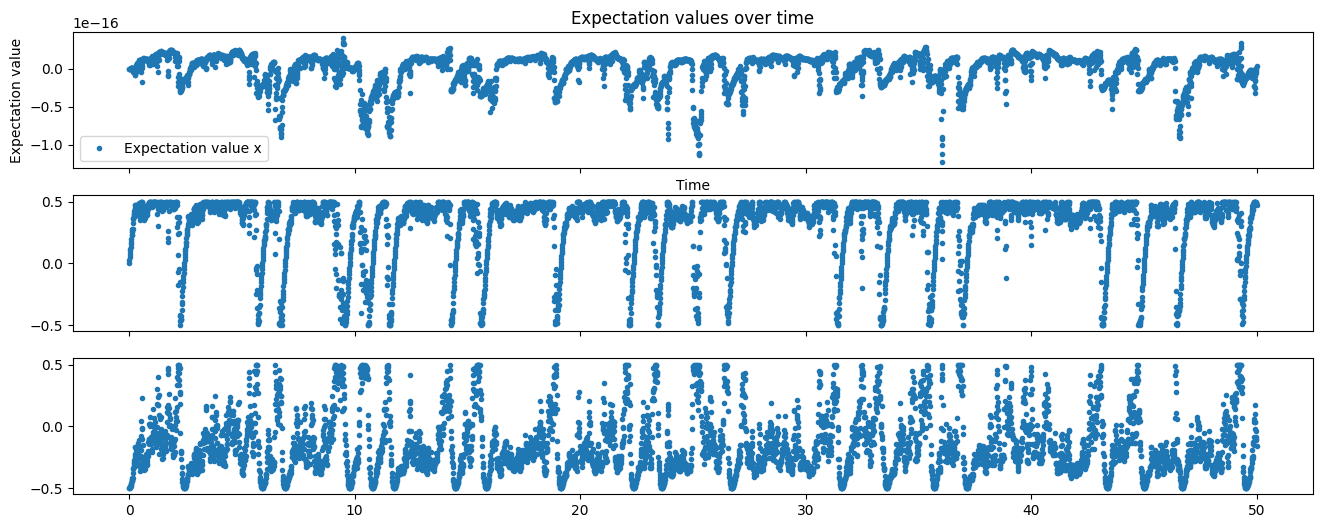

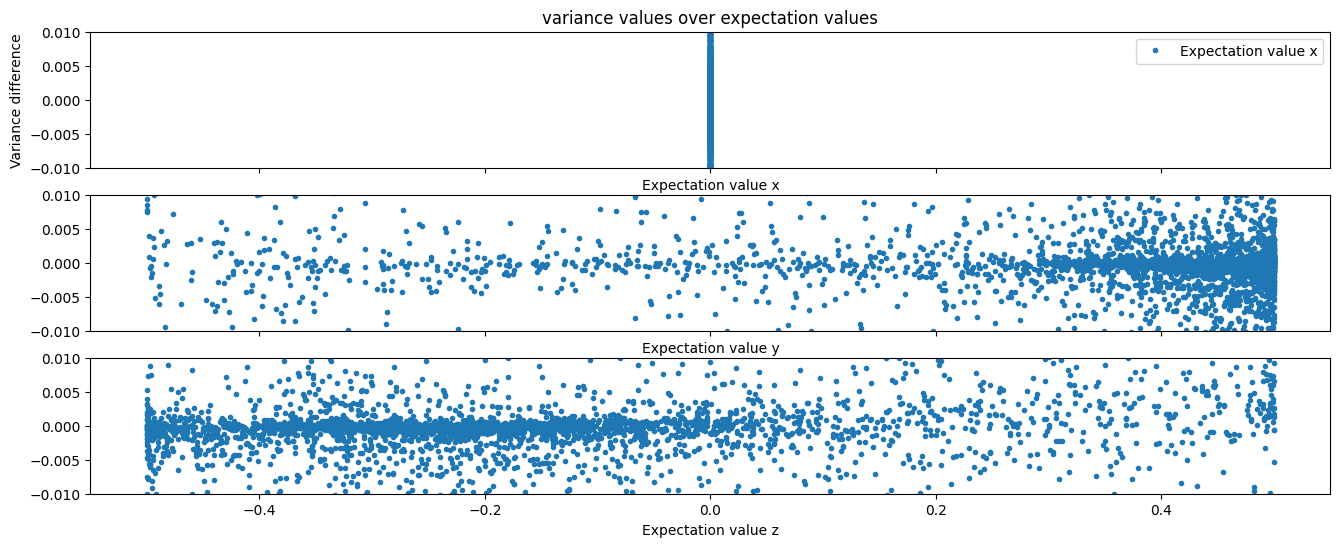

In [36]:
a_x = Experiment.expectation[:, 0]
a_y = Experiment.expectation[:, 1]
a_z = Experiment.expectation[:, 2]

fig, ax = plt.subplots(3, figsize=(16, 6), sharex=True)
ax[0].set_title('Expectation values over time')
ax[0].plot(t_plot, a_x, ".", label='Expectation value x')
ax[1].plot(t_plot, a_y, ".", label='Expectation value y')
ax[2].plot(t_plot, a_z, ".", label='Expectation value z')
ax[0].set_ylabel('Expectation value')
ax[0].set_xlabel('Time')
ax[0].legend()

fig, ax = plt.subplots(3, figsize=(16, 6), sharex=True)

ax[0].plot(a_x[1:], variance_difference, ".", label='Expectation value x')
ax[1].plot(a_y[1:], variance_difference, ".", label='Expectation value y')
ax[2].plot(a_z[1:], variance_difference, ".", label='Expectation value z')
ax[0].set_ylabel('Variance difference')
ax[0].set_xlabel('Expectation value x')
ax[1].set_xlabel('Expectation value y')
ax[2].set_xlabel('Expectation value z')
ax[0].set_title('variance values over expectation values')
ax[0].legend()
ax[0].set_ylim(-0.01, 0.01)
ax[1].set_ylim(-0.01, 0.01)
ax[2].set_ylim(-0.01, 0.01)
